In [1]:
#Importing the necessary modules for the analysis
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

## Loading the data into the pandas dataframe

In [2]:
#reading the data using the pandas module
df=pd.read_csv('Fin_Ethereum.csv',index_col='timestamp')#setting the timestamp as index
df=df.drop(columns=['Unnamed: 0','Target','Target_recreated','Asset_ID'],axis=0)
df

,Count,Open,High,Low,Close,Volume,VWAP,Final_Target
timestamp,,,,,,,,
1514764860,173.0,738.302500,746.00,732.51,738.507500,335.987856,738.839291,-0.004809
1514764920,192.0,738.507500,745.14,732.49,738.260000,232.793141,738.268967,-0.004441
1514764980,120.0,738.332500,745.12,730.00,737.502500,174.138031,737.994457,-0.004206
1514765040,156.0,737.222500,744.69,728.93,737.102500,165.383926,737.303631,-0.002205
1514765100,118.0,736.530000,743.80,727.11,735.705000,193.078039,736.163026,-0.001744
...,...,...,...,...,...,...,...,...
1632182160,2162.0,2973.728686,2976.10,2962.09,2964.711429,751.256906,2968.339295,-0.000346
1632182220,1976.0,2965.461446,2967.95,2958.05,2960.845714,729.113672,2963.499199,-0.000346
1632182280,2262.0,2960.321429,2962.60,2954.14,2957.398571,807.935362,2958.464868,-0.000346


In [3]:
#https://github.com/monchewharry/Crypto_Forecasting_kaggle#21-statistical-inference
import re
import time
from datetime import date, datetime

######################basics
def s2d(secondint):
    '''
    convert the seconds(1970-01-01 00:00:00.000 UTC) format to datetime format.
    secondint can be a list-like input.
    return a datetime64[s]
    '''
    if isinstance(secondint, np.integer):
        t = secondint.astype('datetime64[s]')
    else:
        t = np.int64(secondint).astype('datetime64[s]')
    return t
def d2s(date_str):
    '''
    date_str format:"%Y-%m-%d"
    '''
    if isinstance(date_str, str):
        # given no seconds
        t = np.int32(time.mktime(datetime.strptime(date_str, "%Y-%m-%d").timetuple()))
    else:
        t = [np.int64(pd.Timestamp(s).timestamp()) for s in date_str]
    return t

def ts_with_frequency(series, frequency='1min'):
    '''
    series is given as a minute-by-minute data with index as 'timestamp'.
    ts_frequency(): organize the series with required frequency(1min,5min,15min,1hour,1D)
    (by average over the smallest frequency:1minute)
    '''
    if series.index.name != 'timestamp':
        raise ValueError(f"The series is not with index named 'timestamp'")
    freq_valid_format = ['1min','5min','15min','1H','1D']
    if frequency not in freq_valid_format:
        raise ValueError(f"Wrong input: frequency should be a string as: {freq_valid_format} ")
    freq_num = int(re.findall(r'[0-9]+',frequency)[0]) #1,5,15
    freq_type = re.findall(r"\D+",frequency)[0] #min,H,D,W,M
    #add missing minute data as NAN:don’t fill gaps
    series = series.reindex(range(series.index[0],series.index[-1]+60,60),method='pad')
    #take average to fill in the window
    series.index = s2d(secondint=series.index)
    #The object must have a datetime-like index, average window start from current time
    series = series.resample(rule = frequency,label='right').mean()
    series.index = d2s(date_str=series.index)
    return series

def ohlcv_with_frequency(df, frequency='1min'):
    '''
    df is a dataframe with timestamp + ohlcv columns
    Count	Open	High	Low	Close	Volume	VWAP	
    '''
    #set time index
    df = df.set_index("timestamp")
    if df.index.name != 'timestamp':
        raise ValueError(f"The series is not with index named 'timestamp'")
    freq_valid_format = ['1min','5min','15min','1H','1D']
    if frequency not in freq_valid_format:
        raise ValueError(f"Wrong input: frequency should be a string as: {freq_valid_format} ")
    freq_num = int(re.findall(r'[0-9]+',frequency)[0]) #1,5,15
    freq_type = re.findall(r"\D+",frequency)[0] #min,hour,D,W,M
    #add missing minute data as NAN:don’t fill gaps
    df = df.reindex(range(df.index[0],df.index[-1]+60,60))
    df.index = s2d(secondint=df.index)
    #The object must have a datetime-like index, average window start from current time
    df = df.resample(rule = frequency,label='right').agg({'Count':'sum','Volume':'sum',
                                                    'High':'max', 'Low':'min',
                                                    'Open':'first','Close':'last',
                                                    'VWAP':'mean', 'Final_Target':'last'})
    df.index = d2s(date_str=df.index)
    return df

## Resampling the data into 1D timeframe

In [4]:
#Resampling the data into 1D timeframe
eth_freq = ts_with_frequency(series=df, frequency='1D')
eth_freq=eth_freq.loc[d2s('2018-01-02'):d2s('2021-10-01')]
eth_freq.index = s2d(eth_freq.index)

## Visualisation of the Final_Target

<AxesSubplot:>

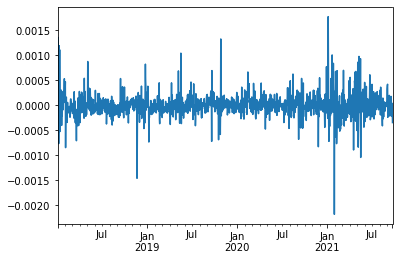

In [5]:
#plotting the final target
eth_freq['Final_Target'].plot()

<AxesSubplot:xlabel='year', ylabel='Final_Target'>

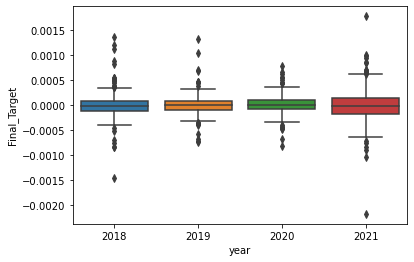

In [6]:
#Box plot of final target in the following years
eth_freq['year'] = [d.year for d in eth_freq.index]
sns.boxplot(x='year', y='Final_Target', data=eth_freq)

In [7]:
!pip3 install pmdarima #installing pmdarima

In [8]:
#importing the necessary libraries
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import  ARIMA

from sklearn.preprocessing import MinMaxScaler,StandardScaler

eth_freq=eth_freq.drop(columns=['year'],axis=0)
scaler = MinMaxScaler()
eth_freq[eth_freq.columns] = scaler.fit_transform(eth_freq[eth_freq.columns])
eth_freq.describe()

,Count,Open,High,Low,Close,Volume,VWAP,Final_Target
count,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000
mean,0.072281,0.151131,0.150887,0.151274,0.151140,0.108690,0.151140,0.550949
std,0.093788,0.212485,0.212359,0.212634,0.212497,0.091552,0.212499,0.060216
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.020670,0.023903,0.023613,0.024094,0.023905,0.047554,0.023905,0.524169
50%,0.033660,0.048971,0.048759,0.049086,0.048975,0.086014,0.048974,0.549280
75%,0.078034,0.155904,0.155637,0.155998,0.155922,0.138032,0.155916,0.574606
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualisation of the Final_Target

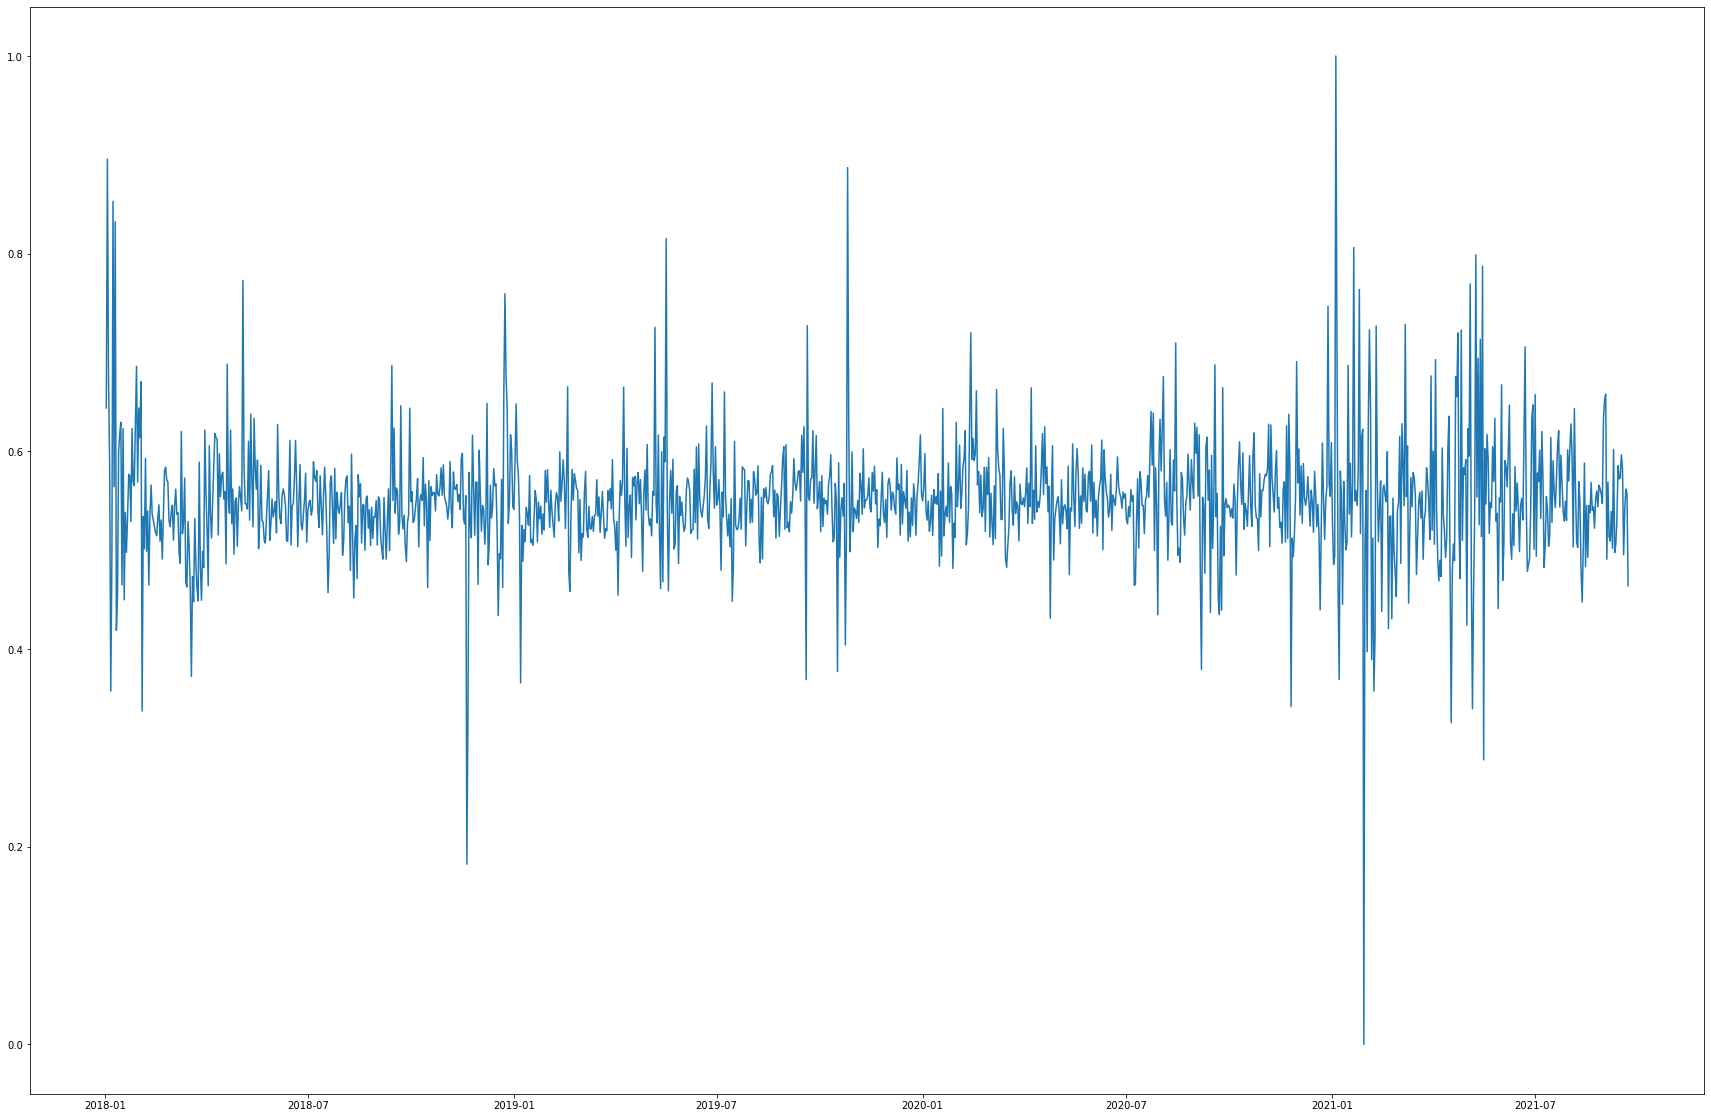

In [9]:
fig=plt.figure(figsize=(30,20))
plt.plot(eth_freq['Final_Target'])

# ADF test to Check if the series is stationarity

In [10]:
# ADF test to Check if the series is stationarity
from statsmodels.tsa.stattools import adfuller
result=adfuller(eth_freq['Final_Target'])

print(f"Test statistics: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical value: {result[4]}")

if result[1]>0.05:
    print('series is not stationary')
else:
    print('series is stationary')

Test statistics: -8.012031828942275
p-value: 2.188338278292849e-12
Critical value: {'1%': -3.435235802905193, '5%': -2.8636977029164603, '10%': -2.5679187656267293}
series is stationary


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2256.221, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2948.899, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=720.300, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3707.884, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3749.409, Time=0.87 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-3567.752, Time=1.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.63 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.35 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-3663.646, Time=1.72 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3782.199, Time=0.99 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3781.934, Time=

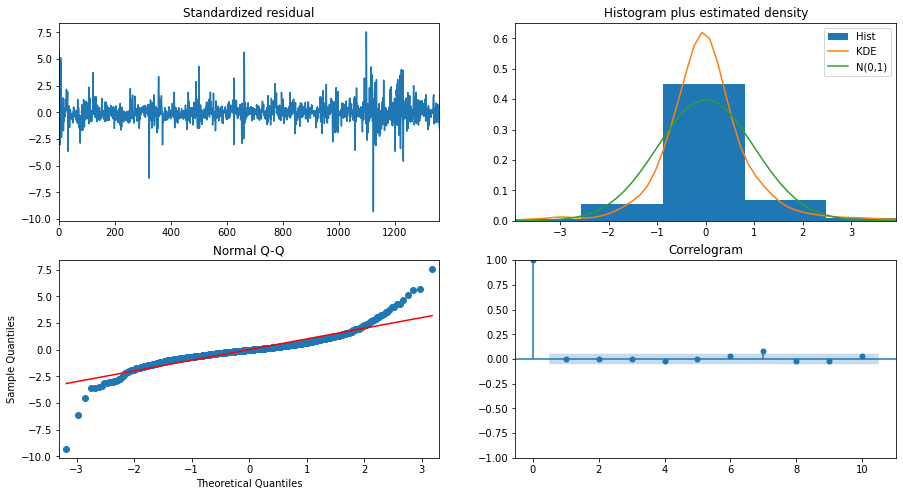

In [11]:
#traing an autoARIMA model
model_autoARIMA = auto_arima(eth_freq['Final_Target'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Best model for 1D time series forecasting:  ARIMA(3,0,0)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from math import sqrt
from matplotlib import pyplot

(951,)


(409,)

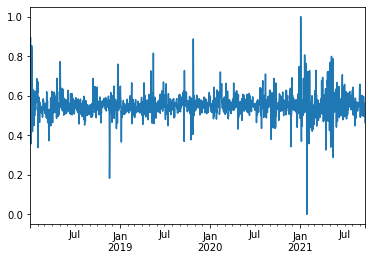

In [13]:
X=eth_freq['Final_Target']
#splitting the data into 70% train and 30% test
train_data, test_data = X[:int(len(X)*0.7)], X[int(len(X)*0.7):]

X.plot()
X.shape
print(train_data.shape)
test_data.shape

In [14]:
X.isnull().sum()

0

## Training ARIMA model

In [15]:
model_fit=model_autoARIMA.fit(train_data)

In [16]:
forecast=model_autoARIMA.predict(n_periods=409,return_conf_int=True)

In [17]:
forecast

(array([0.5559916 , 0.55240289, 0.55113515, 0.55058038, 0.55045428,
        0.55041541, 0.55040356, 0.55040023, 0.55039924, 0.55039895,
        0.55039887, 0.55039884, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55039883, 0.55039883,
        0.55039883, 0.55039883, 0.55039883, 0.55

In [18]:
forecast_df=pd.DataFrame(forecast[0],index=test_data.index,columns=['prediction'])

## Forecasting for the ARIMA(3,0,0)

<AxesSubplot:>

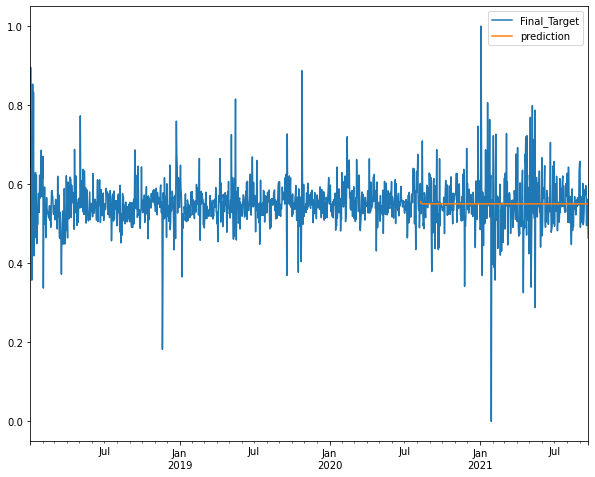

In [19]:
pd.concat([X,forecast_df],axis=1).plot(figsize=(10,8))#the forecast for the test data

## Calculation of Test MSE and MAPE

In [20]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error

print("MSE: ",mean_squared_error(test_data,forecast[0]))
print("MAPE: ",mean_absolute_percentage_error(test_data,forecast[0]))
print("RMSE:", np.sqrt(mean_squared_error(test_data,forecast[0])))

MSE:  0.005892379944365653
MAPE:  6060576941267.824
RMSE: 0.07676183911531598


In [21]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
print("MAPE: ",mean_absolute_percentage_error1(test_data,forecast[0]))

MAPE:  9.230168186377776


## Calculation of Train MSE and MAPE

In [23]:
model_fit1=model_autoARIMA.fit(test_data)

In [24]:
forecast1=model_autoARIMA.predict(n_periods=951,return_conf_int=True)

In [25]:
forecast_df1=pd.DataFrame(forecast1[0],index=train_data.index,columns=['prediction'])

In [26]:
print("MAPE: ",mean_absolute_percentage_error1(train_data,forecast1[0]))

MAPE:  6.269150622582223


In [27]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error

print("MSE: ",mean_squared_error(train_data,forecast1[0]))
print("MAPE: ",mean_absolute_percentage_error(train_data,forecast1[0]))
print("RMSE:", np.sqrt(mean_squared_error(train_data,forecast1[0])))

MSE:  0.002648039752508777
MAPE:  0.06269150622582223
RMSE: 0.051459107575907076
